# Table of contents
Business Understanding
We are consultants hired by US-Health and Human Services to identify the reasons of High Premature deaths in some of the counties.
Find out the variables on which the government should focus to reduce the premature deaths in the US
Data Understanding
Target Variable - "Years of Potential Life Lost Rate per 100,000 people"
Selecting independent variables (List & explaination in Readme.md)
Data Preparation
Data Visualisations
Data Cleaning
Modelling
Building base Model
Model Assessment
Removing Multicollinearity
Model refinement & assessment
Removing variables with high p-values
Check for normality
Check for Homoscedasticity
Model refinement
Evaluation
Choosing the best model
Running the test set on the best model
Recommendations

# Data Understanding:
We chose 34 independent variables and with refinement ended up with 14 variables. Those are as follows:

* Physically Unhealthy Days: Average number of reported physically unhealthy days per month
* LBW: Percentage of births with low birth weight (<2500g)
* Obese: Percentage of adults that report BMI >= 30
* Food Environment Index: Indicator of access to healthy foods - 0 is worst, 10 is best
* Physically Inactive: Percentage of adults that report no leisure-time physical activity
* Chlamydia Rate: Chlamydia cases per 100,000 population
* Teen Birth Rate: Births per 1,000 females ages 15-19
* Preventable Hosp. Rate: Discharges for Ambulatory Care Sensitive Conditions per 100,000 Medicare Enrollees
* Income Ratio: Ratio of household income at the 80th percentile to income at the 20th percentile
* Single-Parent Households: Number of children that live in single-parent households
* Injury Death Rate: Injury mortality rate per 100,000
* Average Daily PM2.5: Average daily amount of fine particulate matter in micrograms per cubic meter
* Drive Alone: Percentage of workers who drive alone to work
*Long Commute - Drives Alone: Among workers who commute in their car alone, the percentage that commute more than 30 minutes

In [12]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations, product
from sklearn.model_selection import KFold,cross_val_predict,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression,RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
pd.set_option('display.max_columns', None)
from library import *


In [44]:
import warnings
warnings.filterwarnings('ignore')


raw = pd.read_csv('analytic_data2019.csv', skiprows=[1,2])
display(raw.shape)
display(raw.head())


xls = pd.ExcelFile('2019 County Health Rankings Data - v2.xls')

Mentalhealth = pd.read_excel(xls, 'Ranked Measure Data',skiprows=[0])


(3193, 534)

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,Premature death CI low,Premature death CI high,Premature death (Black),Premature death (Hispanic),Premature death (White),Poor or fair health raw value,Poor or fair health numerator,Poor or fair health denominator,Poor or fair health CI low,Poor or fair health CI high,Poor physical health days raw value,Poor physical health days numerator,Poor physical health days denominator,Poor physical health days CI low,Poor physical health days CI high,Poor mental health days raw value,Poor mental health days numerator,Poor mental health days denominator,Poor mental health days CI low,Poor mental health days CI high,Low birthweight raw value,Low birthweight numerator,Low birthweight denominator,Low birthweight CI low,Low birthweight CI high,Low birthweight (Black),Low birthweight (Hispanic),Low birthweight (White),Adult smoking raw value,Adult smoking numerator,Adult smoking denominator,Adult smoking CI low,Adult smoking CI high,Adult obesity raw value,Adult obesity numerator,Adult obesity denominator,Adult obesity CI low,Adult obesity CI high,Food environment index raw value,Food environment index numerator,Food environment index denominator,Food environment index CI low,Food environment index CI high,Physical inactivity raw value,Physical inactivity numerator,Physical inactivity denominator,Physical inactivity CI low,Physical inactivity CI high,Access to exercise opportunities raw value,Access to exercise opportunities numerator,Access to exercise opportunities denominator,Access to exercise opportunities CI low,Access to exercise opportunities CI high,Excessive drinking raw value,Excessive drinking numerator,Excessive drinking denominator,Excessive drinking CI low,Excessive drinking CI high,Alcohol-impaired driving deaths raw value,Alcohol-impaired driving deaths numerator,Alcohol-impaired driving deaths denominator,Alcohol-impaired driving deaths CI low,Alcohol-impaired driving deaths CI high,Sexually transmitted infections raw value,Sexually transmitted infections numerator,Sexually transmitted infections denominator,Sexually transmitted infections CI low,Sexually transmitted infections CI high,Teen births raw value,Teen births numerator,Teen births denominator,Teen births CI low,Teen births CI high,Teen births (Black),Teen births (Hispanic),Teen births (White),Uninsured raw value,Uninsured numerator,Uninsured denominator,Uninsured CI low,Uninsured CI high,Primary care physicians raw value,Primary care physicians numerator,Primary care physicians denominator,Primary care physicians CI low,Primary care physicians CI high,Ratio of population to primary care physicians.,Dentists raw value,Dentists numerator,Dentists denominator,Dentists CI low,Dentists CI high,Ratio of population to dentists.,Mental health providers raw value,Mental health providers numerator,Mental health providers denominator,Mental health providers CI low,Mental health providers CI high,Ratio of population to mental health providers.,Preventable hospital stays raw value,Preventable hospital stays numerator,Preventable hospital stays denominator,Preventable hospital stays CI low,Preventable hospital stays CI high,Preventable hospital stays (Black),Preventable hospital stays (Hispanic),Preventable hospital stays (White),Mammography screening raw value,Mammography screening numerator,Mammography screening denominator,Mammography screening CI low,Mammography screening CI high,Mammography screening (Black),Mammography screening (Hispanic),Mammography screening (White),Flu vaccinations raw value,Flu vaccinations numerator,Flu vaccinations denominator,Flu vaccinations CI low,Flu vaccinations CI high,Flu vaccinations (Black),Flu vaccinations (Hispanic),Flu vaccinations (White),High school graduation raw value,High school graduation numerator,High school graduation denominator,High 

# Data Cleaning

In [33]:
#Check the missing value 
raw.isna().sum()

State FIPS Code                         0
County FIPS Code                        0
5-digit FIPS Code                       0
State Abbreviation                      0
Name                                    0
                                     ... 
Female population 18-44 raw value    3120
Female population 45-64 raw value    3120
Female population 65+ raw value      3120
Total female population raw value    3120
Population growth raw value          3120
Length: 534, dtype: int64

In [50]:
#Remove unnecessary columns that contain these text
filter_out = ['numerator', 'denominator', 'CI low', 'CI high', '%', 'death',
              'percentage', 'Percentage', 'ratio', 'Ratio', 'mortality']

# Clean up characters from column names
replace_dict = {' raw value':'', ' - ':'_', '-':'_', '=':'', '/':'_',
                '(':'', ')':'', '.':'', '+':' above', ' ':'_'}

# Manually drop irrelevant columns
drop_list = ['Uninsured_adults', 'Uninsured_children', 'Population']

# Run cleansing function from life_analysis.py
df = data_cleansing(raw, filter_out, replace_dict, drop_list)
df = df.reset_index(drop=True)


# Basis of df to use for modelling. Skip columns 0-6 which are non-numerical
df = df.drop(df.iloc[:, 0:7], axis = 1)
cols = list(df.columns)
df.shape

(3142, 48)

In [35]:
display(df.head())

,Poor_or_fair_health,Poor_physical_health_days,Poor_mental_health_days,Low_birthweight,Adult_smoking,Adult_obesity,Food_environment_index,Physical_inactivity,Access_to_exercise_opportunities,Excessive_drinking,Sexually_transmitted_infections,Teen_births,Uninsured,Primary_care_physicians,Dentists,Mental_health_providers,Preventable_hospital_stays,Mammography_screening,Flu_vaccinations,High_school_graduation,Some_college,Unemployment,Children_in_poverty,Children_in_poverty_Hispanic,Children_in_poverty_White,Income_inequality,Children_in_single_parent_households,Social_associations,Violent_crime,Air_pollution_particulate_matter,Drinking_water_violations,Severe_housing_problems,Driving_alone_to_work,Long_commute_driving_alone,Life_expectancy,Frequent_physical_distress,Frequent_mental_distress,Diabetes_prevalence,Food_insecurity,Limited_access_to_healthy_foods,Insufficient_sleep,Other_primary_care_providers,Median_household_income,Median_household_income_White,Children_eligible_for_free_or_reduced_price_lunch,Residential_segregation_non_white_white,Homeownership,Severe_housing_cost_burden
0,0.167410,3.418464,2.726474,0.058709,0.174271,0.395,5.2,0.222,0.927412,0.168640,179.6,27.531686,0.334537,0.000788,0.000297,0.000593,2763.0,0.33,0.25,0.823529,0.419792,0.025155,0.115,0.163265,0.208333,4.347999,0.414579,6.067961,358.292342,9.4,0.0,0.144928,0.263819,0.005,92.482240,0.102438,0.090094,0.086,0.129,0.349375,0.359073,0.001780,69375.0,81071.0,0.050209,26.711154,0.593596,0.110132
1,0.151764,2.966867,2.569844,0.075893,0.153468,0.400,7.7,0.239,0.895522,0.193905,315.7,15.220700,0.222790,0.000354,0.001041,0.000868,2763.0,0.33,0.25,0.933333,0.530602,0.036260,0.076,0.137705,0.057554,3.215491,0.306210,7.083407,294.617564,9.4,0.0,0.184211,0.453788,0.005,81.367308,0.089543,0.084831,0.082,0.124,0.085740,0.344210,0.001909,80290.0,111250.0,0.186441,11.244810,0.301314,0.081761
2,0.130347,3.443657,3.130305,0.062646,0.149285,0.286,8.1,0.175,0.917033,0.193317,827.6,26.295520,0.128738,0.001083,0.001237,0.003520,2763.0,0.35,0.36,0.801326,0.713571,0.059738,0.122,0.129963,0.055484,3.698226,0.299150,11.770940,1006.657195,9.4,1.0,0.162729,0.758242,0.138,79.021796,0.100924,0.098440,0.078,0.120,0.051138,0.297393,0.001801,78579.0,93595.0,0.452069,30.625017,0.601083,0.126524
3,0.262706,5.684245,4.857296,0.059021,0.333823,0.313,3.0,0.275,0.956680,0.190175,2897.6,68.498378,0.238981,0.001113,0.001328,0.020027,818.0,0.18,0.12,0.548276,0.337861,0.137945,0.355,0.162162,0.023026,5.224164,0.376018,3.895815,358.292342,9.4,1.0,0.595768,0.248537,0.010,71.946400,0.185066,0.178050,0.068,0.217,0.419876,0.351754,0.001715,45582.0,111250.0,0.891728,57.267414,0.632405,0.089158
4,0.154541,3.745194,3.511147,0.058709,0.200417,0.386,6.8,0.243,0.054162,0.224493,448.4,45.871560,0.229381,0.000000,0.001153,0.000000,2063.0,0.36,0.30,0.833333,0.625000,0.063380,0.191,0.157500,0.100584,3.911152,0.358852,11.135857,0.000000,9.4,0.0,0.160000,0.589041,0.034,78.867605,0.112543,0.115655,0.097,0.127,0.176632,0.313915,0.003460,70094.0,95855.0,0.682927,26.711154,0.572626,0.056075


In [36]:
# Remove outliers that lies k std deviations away from mean
k = 3
# Run remove outlier function from life_analysis.py
df = remove_outliers(df, k)

21.1% of rows removed
2480 rows remains


# EDA

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
df

AttributeError: 'float' object has no attribute 'mean'

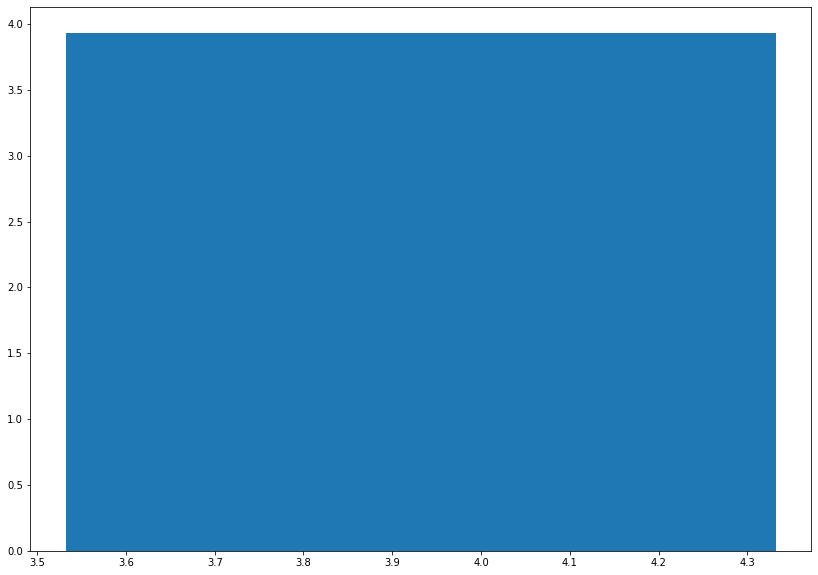

In [51]:

plt.figure(figsize=(14,10))
states = Mentalhealth['Mentally Unhealthy Days'].mean()
plt.bar(states,states)
plt.axhline(y=states.mean(),c='r')
plt.axhline(y=states.median(),c='g')
plt.xticks(rotation=2.5)
plt.ylim([2,3])
plt.title("Poor_mental_health_days for Each State")
plt.ylabel("Days")
plt.xlabel("States")